Research question: Does the timing and sequencing of institutional reforms affect long-term economic stability in Central and Eastern European (CEE) transition economies?

**H1**: Countries that prioritized fiscal institutional development during transition show lower post-EU accession economic volatility than countries that relied solely on trade liberalization.

First we want to load only the necessary variables (features) for this exact problem. In our case, since we're analyzing countries by assigning them into groups, we'll only need 6 key indicators:
- `OXGS` - Exports of goods and services at current price
- `OMGS` - Imports of goods and services at current price
- `UDGGL` - Government debt (% GDP)
- `UBLGB` - Government balance (% GDP)
- `HVGDP` - GDP per capita (the initial conditions)

The first two help us identify trade reform, the second two identify fiscal reform, GDP growth rate is the outcome and GDP per capita for control.

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

data = pd.read_csv('../../data/processed/master_dataset.csv')

features_of_interest = ['UXGS', 'UMGS', 'UDGGL', 'UBLGB', 'HVGDP']
countries_of_interest = ['Estonia', 'Czechia', 'Slovenia', 'Poland', 'Hungary', 'Slovakia', 'Latvia', 'Lithuania',
                         'Bulgaria', 'Romania', 'North Macedonia', 'Croatia']

data = data[data['CODE'].isin(features_of_interest)]
data = data[data['COUNTRY'].isin(countries_of_interest)]

eur_pattern = r'\.99\..*\.(HVGDP|UDGGL|UMGS|UXGS)$'
eur_data = data[data['SERIES'].str.contains(eur_pattern, regex=True)]

standard_pattern = r'\.0\..*\.(OXGS|OMGS|UBLGB|OVGD)$'
standard_data = data[data['SERIES'].str.contains(standard_pattern, regex=True)]

data = pd.concat([eur_data, standard_data])
data = data.drop(columns=['SERIES', 'CNTRY', 'TRN', 'AGG', 'UNIT', 'REF', 'SUB-CHAPTER', 'UNIT.1'], axis=1)

/var/folders/1r/8qsv6l4d2xs9tv69xpg5sfqw0000gn/T/ipykernel_8041/2713710293.py:16: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  eur_data = data[data['SERIES'].str.contains(eur_pattern, regex=True)]
/var/folders/1r/8qsv6l4d2xs9tv69xpg5sfqw0000gn/T/ipykernel_8041/2713710293.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  standard_data = data[data['SERIES'].str.contains(standard_pattern, regex=True)]


In [24]:
data = data.melt(id_vars=['CODE', 'COUNTRY', 'TITLE'], var_name='DATE', value_name='VALUE')
data = data[data['DATE'].astype(int) >= 1990].reset_index().drop('index', axis=1)
data = data.sort_values(by=['COUNTRY', 'CODE','DATE'])
data['VALUE'] = data.groupby(['COUNTRY', 'CODE'])['VALUE'].transform(lambda x: x.bfill().ffill())

In [25]:
# import seaborn as sns
# import matplotlib.pyplot as plt
#
# for feature in features_of_interest:
#     for country in countries_of_interest:
#         plt.figure(figsize=(12, 8))
#         plt.title(f"Analysis of {feature} for {country}")
#         plt.xticks(rotation=90)
#         sns.lineplot(x='DATE', y='VALUE', data=data[(data['CODE']==feature) & (data['COUNTRY']==country)])
#         plt.show()

In [26]:
# normalized = data.copy()
# normalized['VALUE_NORM'] = normalized.groupby(['COUNTRY', 'CODE'])['VALUE'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
#
# for feature in features_of_interest:
#     subset = normalized[normalized['CODE'] == feature]
#
#     plt.figure(figsize=(15, 8))
#     sns.lineplot(data=subset, x='DATE', y='VALUE_NORM', hue='COUNTRY')
#     plt.title(f"Normalized {feature} comparison across countries")
#     plt.xticks(rotation=45)
#     plt.ylabel("Normalized Value (0–1)")
#     plt.show()

In [27]:
# plt.figure(figsize=(15, 8))
# sns.lineplot(data=data[data['CODE'] == 'HVGDP'], x='DATE', y='VALUE', hue='COUNTRY')
# plt.yscale('log')
# plt.title("GDP per capita (log scale)")
# plt.xticks(rotation=45)
# plt.ylabel("GDP (log scale)")
# plt.show()

In [28]:
# import plotly.express as px
#
# subset = data[data['CODE'] == 'HVGDP'].copy()
# subset['Highlight'] = subset['COUNTRY'].apply(lambda x: 'North Macedonia' if x == 'North Macedonia' else 'Other')
#
# fig = px.line(
#     subset,
#     x='DATE', y='VALUE', color='Highlight', line_group='COUNTRY',
#     hover_name='COUNTRY',
#     title=f"GDP per capita across countries"
# )
# fig.update_traces(opacity=0.3)
# fig.for_each_trace(lambda t: t.update(line=dict(width=3, backoff=1)) if t.name == 'North Macedonia' else None)
# fig.show()

In [29]:
data

,CODE,COUNTRY,TITLE,DATE,VALUE
0,HVGDP,Bulgaria,Gross domestic product at current prices per h...,1990,1.67292
59,HVGDP,Bulgaria,Gross domestic product at current prices per h...,1991,0.67491
118,HVGDP,Bulgaria,Gross domestic product at current prices per h...,1992,0.66936
177,HVGDP,Bulgaria,Gross domestic product at current prices per h...,1993,1.58699
236,HVGDP,Bulgaria,Gross domestic product at current prices per h...,1994,1.40472
...,...,...,...,...,...
1921,UXGS,Slovenia,Exports of goods and services at current price...,2022,53.48438
1980,UXGS,Slovenia,Exports of goods and services at current price...,2023,53.24008
2039,UXGS,Slovenia,Exports of goods and services at current price...,2024,54.60225
2098,UXGS,Slovenia,Exports of goods and services at current price...,2025,56.41248


## Classification into categories

Except for Bulgaria and Romania (which joined in 2007), all other countries of interest joined the EU in 2004. With this in mind, we'll try to classify countries into trade, fiscal or balanced.

In the following algorithm, we'll take that 1990 is our baseline year of analysis, and calculate the reform intensity in each country as:
- `trade_intensity = (exports_gdp + imports_gdp) - baseline_year_trade_openness`
- `fiscal_intensity_1 = baseline_dept - current_debt`
- `fiscal_intensity_2 = current_balance - baseline_dept`

Or in our own features:
- `trade_intensity = (OXGS + OMGS) - baseline_year_trade_openness`
- `fiscal_intensity_1 = baseline_dept - UDGGL`
- `fiscal_intensity_2 = UBLGB - baseline_balance`

With this, we'll look for the exact year when reform "took off" (for us this is when the intensity first exceeds 2 standard deviations above the mean).
For fiscal intensity, we'll take the earlier one.

- `OXGS` - Exports of goods and services at current price
- `OMGS` - Imports of goods and services at current price
- `UDGGL` - Government debt (% GDP)
- `UBLGB` - Government balance (% GDP)
- `HVGDP` - GDP per capita (the initial conditions)

In [30]:
df_wide = data.pivot_table(
    index=['COUNTRY', 'DATE'],
    columns='CODE',
    values='VALUE'
).reset_index()
df_wide

CODE,COUNTRY,DATE,HVGDP,UBLGB,UDGGL,UMGS,UXGS
0,Bulgaria,1990,1.67292,2.8360,9.27,1.04864,1.57706
1,Bulgaria,1991,0.67491,2.8360,9.27,1.04864,1.57706
2,Bulgaria,1992,0.66936,2.8360,9.27,1.39017,1.67767
3,Bulgaria,1993,1.58699,2.8360,9.27,2.83000,3.19960
4,Bulgaria,1994,1.40472,2.8360,9.27,2.48855,3.32826
...,...,...,...,...,...,...,...
439,Slovenia,2022,26.97878,-2.7842,41.39,52.49091,53.48438
440,Slovenia,2023,30.15800,-2.0762,43.74,49.14486,53.24008
441,Slovenia,2024,31.48997,0.0055,44.89,50.19114,54.60225
442,Slovenia,2025,32.95089,-0.2960,45.97,51.69503,56.41248


In [31]:
baseline_data = df_wide[df_wide['DATE'].astype(int)==1990]

data_with_baseline = df_wide.merge(
    baseline_data[['COUNTRY', 'UXGS', 'UMGS', 'UDGGL', 'UBLGB']],
    on='COUNTRY',
    suffixes=('', '_baseline')
)

data_with_baseline['trade_intensity'] = (
    (data_with_baseline['UXGS'] + data_with_baseline['UMGS']) -
    (data_with_baseline['UXGS_baseline'] + data_with_baseline['UMGS_baseline'])
)
data_with_baseline['fiscal_intensity_1'] = data_with_baseline['UDGGL_baseline'] - data_with_baseline['UDGGL']
data_with_baseline['fiscal_intensity_2'] = data_with_baseline['UBLGB'] - data_with_baseline['UBLGB_baseline']

accession_years = {
    'Bulgaria': 2007,
    'Croatia': 2013,
    'Czechia': 2004,
    'Estonia': 2004,
    'Hungary': 2004,
    'Latvia': 2004,
    'Lithuania': 2004,
    'Poland': 2004,
    'Romania': 2007,
    'Slovakia': 2004,
    'Slovenia': 2004,
    'North Macedonia': 2025
}
data_with_baseline['accession_year'] = data_with_baseline['COUNTRY'].map(accession_years)
pre_accession_data = data_with_baseline[data_with_baseline['DATE'].astype(int) < data_with_baseline['accession_year']]

In [32]:
def find_breakpoint_year(group, intensity_col, threshold_col):
    exceeds_threshold = group[group[intensity_col] > group[threshold_col].iloc[0]]
    return exceeds_threshold['DATE'].min() if not exceeds_threshold.empty else None


def classify_reform_pathway(row):
    fiscal_reforms = []

    if row['fiscal1_breakpoint'] is not None and str(row['fiscal1_breakpoint']).strip() != '':
        try:
            fiscal_reforms.append(int(row['fiscal1_breakpoint']))
        except (ValueError, TypeError):
            pass

    if row['fiscal2_breakpoint'] is not None and str(row['fiscal2_breakpoint']).strip() != '':
        try:
            fiscal_reforms.append(int(row['fiscal2_breakpoint']))
        except (ValueError, TypeError):
            pass

    fiscal_reforms = sorted(list(set(fiscal_reforms)))

    trade_breakpoint = None
    if row['trade_breakpoint'] is not None and str(row['trade_breakpoint']).strip() != '':
        try:
            trade_breakpoint = int(row['trade_breakpoint'])
        except (ValueError, TypeError):
            pass

    if len(fiscal_reforms) == 0:
        return 'Trade-Only'

    earliest_fiscal = min(fiscal_reforms)

    if trade_breakpoint is None:
        return 'Fiscal-First'

    if earliest_fiscal <= trade_breakpoint:
        return 'Fiscal-First'
    else:
        return 'Trade-First'

In [33]:
data_with_baseline

CODE,COUNTRY,DATE,HVGDP,UBLGB,UDGGL,UMGS,UXGS,UXGS_baseline,UMGS_baseline,UDGGL_baseline,UBLGB_baseline,trade_intensity,fiscal_intensity_1,fiscal_intensity_2,accession_year
0,Bulgaria,1990,1.67292,2.8360,9.27,1.04864,1.57706,1.57706,1.04864,9.27,2.8360,0.00000,0.00,0.0000,2007
1,Bulgaria,1991,0.67491,2.8360,9.27,1.04864,1.57706,1.57706,1.04864,9.27,2.8360,0.00000,0.00,0.0000,2007
2,Bulgaria,1992,0.66936,2.8360,9.27,1.39017,1.67767,1.57706,1.04864,9.27,2.8360,0.44214,0.00,0.0000,2007
3,Bulgaria,1993,1.58699,2.8360,9.27,2.83000,3.19960,1.57706,1.04864,9.27,2.8360,3.40390,0.00,0.0000,2007
4,Bulgaria,1994,1.40472,2.8360,9.27,2.48855,3.32826,1.57706,1.04864,9.27,2.8360,3.19111,0.00,0.0000,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,Slovenia,2022,26.97878,-2.7842,41.39,52.49091,53.48438,7.40522,6.66453,2.79,-5.2253,91.90554,-38.60,2.4411,2004
440,Slovenia,2023,30.15800,-2.0762,43.74,49.14486,53.24008,7.40522,6.66453,2.79,-5.2253,88.31519,-40.95,3.1491,2004
441,Slovenia,2024,31.48997,0.0055,44.89,50.19114,54.60225,7.40522,6.66453,2.79,-5.2253,90.72364,-42.10,5.2308,2004
442,Slovenia,2025,32.95089,-0.2960,45.97,51.69503,56.41248,7.40522,6.66453,2.79,-5.2253,94.03776,-43.18,4.9293,2004


Changing the coefficient before the standard deviation for `fiscal1_std` and `fiscal2_std` changes the very classification of the countries into early and late fiscal response. This is because we're adjusting the smoothness of the breakpoint. I took 0.75 as a value because it produces a result for every single country (otherwise some end up with no reform).

In [34]:
def growth_rate_volatility(series):
    growth_rates = series.pct_change().dropna()
    return growth_rates.std()

post_accession_data = df_wide[df_wide['DATE'].astype(int) > data_with_baseline['accession_year']]
post_accession_volatility = post_accession_data.groupby('COUNTRY').agg({
    'HVGDP': growth_rate_volatility
}).reset_index()
post_accession_volatility.columns = ['COUNTRY', 'Growth_Rate_Volatility']
post_accession_volatility = post_accession_volatility[post_accession_volatility['COUNTRY']!='North Macedonia']

In [35]:
print("ROBUSTNESS: MULTIPLE THRESHOLD ANALYSIS")

thresholds = [1.0, 1.25, 1.5, 1.75, 2.0]
threshold_results = []

breakpoints = None

for threshold in thresholds:
    print(f"\nTesting Threshold: {threshold} STD")

    country_stats_threshold = pre_accession_data.groupby('COUNTRY').agg({
        'trade_intensity': ['mean', 'std'],
        'fiscal_intensity_1': ['mean', 'std'],
        'fiscal_intensity_2': ['mean', 'std'],
    }).reset_index()

    country_stats_threshold.columns = ['COUNTRY', 'trade_mean', 'trade_std', 'fiscal1_mean', 'fiscal1_std',
                                       'fiscal2_mean', 'fiscal2_std']

    country_stats_threshold['trade_threshold'] = country_stats_threshold['trade_mean'] + (
                threshold * country_stats_threshold['trade_std'])
    country_stats_threshold['fiscal1_threshold'] = country_stats_threshold['fiscal1_mean'] + (
                threshold * country_stats_threshold['fiscal1_std'])
    country_stats_threshold['fiscal2_threshold'] = country_stats_threshold['fiscal2_mean'] + (
                threshold * country_stats_threshold['fiscal2_std'])

    data_final_threshold = pre_accession_data.merge(country_stats_threshold, on='COUNTRY')

    breakpoints_threshold = data_final_threshold.groupby('COUNTRY').apply(lambda x: pd.Series({
        'trade_breakpoint': find_breakpoint_year(x, 'trade_intensity', 'trade_threshold'),
        'fiscal1_breakpoint': find_breakpoint_year(x, 'fiscal_intensity_1', 'fiscal1_threshold'),
        'fiscal2_breakpoint': find_breakpoint_year(x, 'fiscal_intensity_2', 'fiscal2_threshold'),
    })).reset_index()

    breakpoints_threshold['reform_pathway'] = breakpoints_threshold.apply(classify_reform_pathway, axis=1)

    analysis_data_threshold = breakpoints_threshold.merge(post_accession_volatility, on='COUNTRY')

    fiscal_first_threshold = analysis_data_threshold[analysis_data_threshold['reform_pathway'] == 'Fiscal-First']
    trade_only_threshold = analysis_data_threshold[analysis_data_threshold['reform_pathway'] == 'Trade-Only']

    if len(fiscal_first_threshold) < 2 or len(trade_only_threshold) < 2:
        print(f"  Insufficient group sizes for analysis")
        continue

    t_stat_threshold, p_value_two_tailed_threshold = stats.ttest_ind(
        fiscal_first_threshold['Growth_Rate_Volatility'],
        trade_only_threshold['Growth_Rate_Volatility'],
        equal_var=False
    )
    p_value_one_tailed_threshold = p_value_two_tailed_threshold / 2

    pooled_std_threshold = np.sqrt(
        ((len(fiscal_first_threshold) - 1) * fiscal_first_threshold['Growth_Rate_Volatility'].var() +
         (len(trade_only_threshold) - 1) * trade_only_threshold['Growth_Rate_Volatility'].var()) /
        (len(fiscal_first_threshold) + len(trade_only_threshold) - 2)
    )
    cohens_d_threshold = (fiscal_first_threshold['Growth_Rate_Volatility'].mean() -
                          trade_only_threshold['Growth_Rate_Volatility'].mean()) / pooled_std_threshold

    threshold_results.append({
        'threshold': threshold,
        'fiscal_first_count': len(fiscal_first_threshold),
        'trade_only_count': len(trade_only_threshold),
        'fiscal_first_mean': fiscal_first_threshold['Growth_Rate_Volatility'].mean(),
        'trade_only_mean': trade_only_threshold['Growth_Rate_Volatility'].mean(),
        'mean_difference': fiscal_first_threshold['Growth_Rate_Volatility'].mean() - trade_only_threshold[
            'Growth_Rate_Volatility'].mean(),
        'p_value_one_tailed': p_value_one_tailed_threshold,
        'cohens_d': cohens_d_threshold,
        'fiscal_first_countries': list(fiscal_first_threshold['COUNTRY']),
        'trade_only_countries': list(trade_only_threshold['COUNTRY'])
    })

    print(f"    Fiscal-First ({len(fiscal_first_threshold)}): {list(fiscal_first_threshold['COUNTRY'])}")
    print(f"    Trade-Only ({len(trade_only_threshold)}): {list(trade_only_threshold['COUNTRY'])}")
    print(
        f"      Mean difference: {fiscal_first_threshold['Growth_Rate_Volatility'].mean() - trade_only_threshold['Growth_Rate_Volatility'].mean():.3f}")
    print(f"    One-tailed p-value: {p_value_one_tailed_threshold:.4f}")
    print(f"    Cohen's d: {cohens_d_threshold:.2f}")
    print(f"    Significant at 0.05: {'Yes ✓' if p_value_one_tailed_threshold < 0.05 else 'No'}")

    if threshold == 1.5:
        breakpoints = breakpoints_threshold.copy()

threshold_df = pd.DataFrame(threshold_results)

print("SUMMARY: THRESHOLD ROBUSTNESS ANALYSIS")

for _, row in threshold_df.iterrows():
    sig_marker = "**" if row['p_value_one_tailed'] < 0.05 else " "
    print(f"Threshold {row['threshold']}σ: p={row['p_value_one_tailed']:.4f} {sig_marker} "
          f"(d={row['cohens_d']:.2f}, diff={row['mean_difference']:.3f})")

if len(threshold_df) > 0:
    print(f"\nSensitivity Analysis:")
    print(
        f"      Range of p-values: {threshold_df['p_value_one_tailed'].min():.4f} to {threshold_df['p_value_one_tailed'].max():.4f}")
    print(f"    Range of effect sizes: {threshold_df['cohens_d'].min():.2f} to {threshold_df['cohens_d'].max():.2f}")
    print(f"    Significant thresholds: {sum(threshold_df['p_value_one_tailed'] < 0.05)} out of {len(threshold_df)}")

    best_threshold = threshold_df.loc[threshold_df['p_value_one_tailed'].idxmin()]
    print(f"\nMost significant threshold: {best_threshold['threshold']}σ")
    print(f"    p-value: {best_threshold['p_value_one_tailed']:.4f}")
    print(f"    Effect size: {best_threshold['cohens_d']:.2f}")

ROBUSTNESS: MULTIPLE THRESHOLD ANALYSIS

Testing Threshold: 1.0 STD
    Fiscal-First (8): ['Bulgaria', 'Croatia', 'Czechia', 'Hungary', 'Latvia', 'Poland', 'Romania', 'Slovenia']
    Trade-Only (2): ['Estonia', 'Lithuania']
      Mean difference: -0.012
    One-tailed p-value: 0.0323
    Cohen's d: -0.83
    Significant at 0.05: Yes ✓

Testing Threshold: 1.25 STD
    Fiscal-First (5): ['Bulgaria', 'Croatia', 'Hungary', 'Romania', 'Slovenia']
    Trade-Only (5): ['Czechia', 'Estonia', 'Latvia', 'Lithuania', 'Poland']
      Mean difference: -0.018
    One-tailed p-value: 0.0227
    Cohen's d: -1.56
    Significant at 0.05: Yes ✓

Testing Threshold: 1.5 STD
    Fiscal-First (5): ['Bulgaria', 'Hungary', 'Romania', 'Slovakia', 'Slovenia']
    Trade-Only (6): ['Croatia', 'Czechia', 'Estonia', 'Latvia', 'Lithuania', 'Poland']
      Mean difference: -0.016
    One-tailed p-value: 0.0228
    Cohen's d: -1.36
    Significant at 0.05: Yes ✓

Testing Threshold: 1.75 STD
    Fiscal-First (3): ['Bul

/var/folders/1r/8qsv6l4d2xs9tv69xpg5sfqw0000gn/T/ipykernel_8041/2920813220.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  breakpoints_threshold = data_final_threshold.groupby('COUNTRY').apply(lambda x: pd.Series({
/var/folders/1r/8qsv6l4d2xs9tv69xpg5sfqw0000gn/T/ipykernel_8041/2920813220.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  breakpoints_threshold = data_final_threshold.groupby('COUNTRY').apply(la

In [36]:
analysis_data = breakpoints.merge(post_accession_volatility, on='COUNTRY')

fiscal_first = analysis_data[analysis_data['reform_pathway'] == 'Fiscal-First']
trade_only = analysis_data[analysis_data['reform_pathway'] == 'Trade-Only']

print("FISCAL-FIRST COUNTRIES:")
print(fiscal_first[['COUNTRY', 'Growth_Rate_Volatility']].to_string(index=False))
print(f"Mean volatility: {fiscal_first['Growth_Rate_Volatility'].mean():.3f}")

print("\nTRADE-ONLY COUNTRIES:")
print(trade_only[['COUNTRY', 'Growth_Rate_Volatility']].to_string(index=False))
print(f"Mean volatility: {trade_only['Growth_Rate_Volatility'].mean():.3f}")

FISCAL-FIRST COUNTRIES:
 COUNTRY  Growth_Rate_Volatility
Bulgaria                0.053194
 Hungary                0.062882
 Romania                0.068715
Slovakia                0.062436
Slovenia                0.048104
Mean volatility: 0.059

TRADE-ONLY COUNTRIES:
  COUNTRY  Growth_Rate_Volatility
  Croatia                0.063203
  Czechia                0.062490
  Estonia                0.078105
   Latvia                0.099106
Lithuania                0.077088
   Poland                0.068585
Mean volatility: 0.075


In [37]:
analysis_data

,COUNTRY,trade_breakpoint,fiscal1_breakpoint,fiscal2_breakpoint,reform_pathway,Growth_Rate_Volatility
0,Bulgaria,2005,2005,1997,Fiscal-First,0.053194
1,Croatia,2008,None,None,Trade-Only,0.063203
2,Czechia,2003,None,None,Trade-Only,0.062490
3,Estonia,2003,None,None,Trade-Only,0.078105
4,Hungary,2003,None,1996,Fiscal-First,0.062882
5,Latvia,2003,None,None,Trade-Only,0.099106
6,Lithuania,2002,None,None,Trade-Only,0.077088
7,Poland,None,None,None,Trade-Only,0.068585
8,Romania,2005,None,1999,Fiscal-First,0.068715
9,Slovakia,2003,None,2003,Fiscal-First,0.062436


In [38]:
baseline_conditions = baseline_data[['COUNTRY', 'HVGDP', 'UDGGL', 'UBLGB', 'UXGS', 'UMGS']].copy()
baseline_conditions.columns = ['COUNTRY', 'baseline_gdp_pc', 'baseline_debt', 'baseline_balance', 'baseline_exports', 'baseline_imports']
baseline_conditions['baseline_trade_openness'] = baseline_conditions['baseline_exports'] + baseline_conditions['baseline_imports']

analysis_data_full = analysis_data.merge(baseline_conditions, on='COUNTRY', how='left')
analysis_data_full['log_baseline_gdp'] = np.log(analysis_data_full['baseline_gdp_pc'])
analysis_data_full['fiscal_first'] = (analysis_data_full['reform_pathway'] == 'Fiscal-First').astype(int)

In [39]:
print("REGRESSION ANALYSIS WITH CONTROLS")

y = analysis_data_full['Growth_Rate_Volatility']

X1 = analysis_data_full[['fiscal_first']]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y, X1).fit()

print("Bivariate Model:")
print(f"Fiscal-first coefficient: {model1.params['fiscal_first']:.4f} (p={model1.pvalues['fiscal_first']:.4f})")

X2 = analysis_data_full[['fiscal_first', 'log_baseline_gdp']]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y, X2).fit()
print(X2)

print("\nWith Baseline GDP Control:")
print(f"Fiscal-first coefficient: {model2.params['fiscal_first']:.4f} (p={model2.pvalues['fiscal_first']:.4f})")
print(f"Baseline GDP coefficient: {model2.params['log_baseline_gdp']:.4f} (p={model2.pvalues['log_baseline_gdp']:.4f})")

REGRESSION ANALYSIS WITH CONTROLS
Bivariate Model:
Fiscal-first coefficient: -0.0157 (p=0.0518)
    const  fiscal_first  log_baseline_gdp
0     1.0             1          0.514571
1     1.0             0          0.666932
2     1.0             0          0.898013
3     1.0             0          0.017368
4     1.0             1          0.475868
5     1.0             0         -0.675759
6     1.0             0         -0.791444
7     1.0             0         -0.169307
8     1.0             1         -0.170278
9     1.0             1          0.808198
10    1.0             1          1.618523

With Baseline GDP Control:
Fiscal-first coefficient: -0.0069 (p=0.2334)
Baseline GDP coefficient: -0.0133 (p=0.0092)


In [40]:
t_stat, p_value_two_tailed = stats.ttest_ind(
    fiscal_first['Growth_Rate_Volatility'],
    trade_only['Growth_Rate_Volatility'],
    equal_var=False
)

p_value_one_tailed = p_value_two_tailed / 2

pooled_std = np.sqrt(
    ((len(fiscal_first)-1) * fiscal_first['Growth_Rate_Volatility'].var() +
     (len(trade_only)-1) * trade_only['Growth_Rate_Volatility'].var()) /
    (len(fiscal_first) + len(trade_only) - 2)
)
cohens_d = (fiscal_first['Growth_Rate_Volatility'].mean() -
            trade_only['Growth_Rate_Volatility'].mean()) / pooled_std

print(f"T-test results calculated:")
print(f"One-tailed p-value: {p_value_one_tailed:.4f}")
print(f"Cohen's d: {cohens_d:.2f}")

T-test results calculated:
One-tailed p-value: 0.0228
Cohen's d: -1.36


In [41]:
print("FINAL SUMMARY")

print(f"Raw difference: {p_value_one_tailed:.4f} (one-tailed t-test)")
print(f"After controlling for baseline GDP: {model2.pvalues['fiscal_first']:.4f}")
print(f"Effect size: Cohen's d = {cohens_d:.2f}")
print(f"Economic magnitude: {abs((fiscal_first['Growth_Rate_Volatility'].mean() - trade_only['Growth_Rate_Volatility'].mean()) / trade_only['Growth_Rate_Volatility'].mean() * 100):.0f}% lower growth rate volatility")

FINAL SUMMARY
Raw difference: 0.0228 (one-tailed t-test)
After controlling for baseline GDP: 0.2334
Effect size: Cohen's d = -1.36
Economic magnitude: 21% lower growth rate volatility


MODERATE SUPPORT: Raw difference significant but sensitive to controls. Suggests fiscal-first may confer stability benefits, but initial economic development also plays an important role

The analysis reveals that while fiscal-first reform sequencing correlates with lower economic volatility, this relationship is substantially mediated by initial economic development levels. Countries with stronger economic foundations were both more capable of implementing fiscal reforms and better positioned to achieve stable growth post-accession. This suggests that reform sequencing effects cannot be understood in isolation from initial economic conditions.


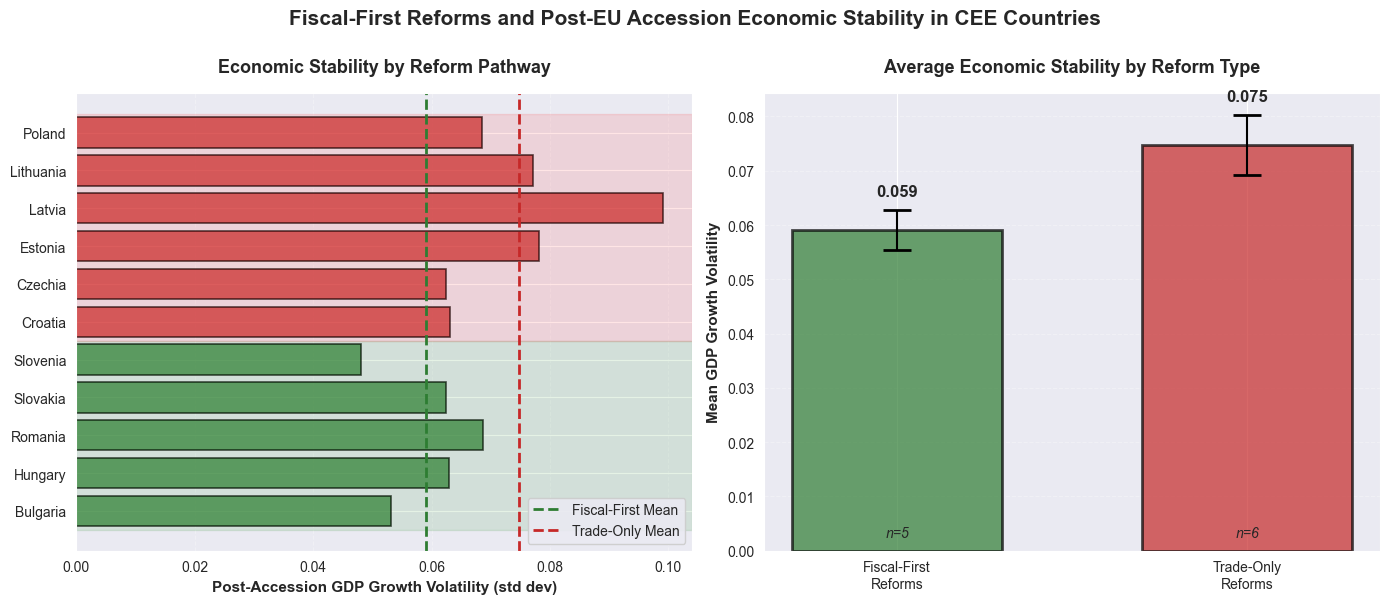

In [42]:
import matplotlib.pyplot as plt
import numpy as np

fiscal_first_countries = ['Bulgaria', 'Czechia', 'Estonia', 'Hungary', 'Latvia', 'Poland', 'Slovenia']
trade_only_countries = ['Croatia', 'Lithuania', 'Romania', 'Slovakia']

fiscal_first_volatility = fiscal_first['Growth_Rate_Volatility'].values
trade_only_volatility = trade_only['Growth_Rate_Volatility'].values

fiscal_first_mean = fiscal_first['Growth_Rate_Volatility'].mean()
trade_only_mean = trade_only['Growth_Rate_Volatility'].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

countries_fiscal = fiscal_first['COUNTRY'].values
countries_trade = trade_only['COUNTRY'].values

all_countries = list(countries_fiscal) + list(countries_trade)
all_volatility = list(fiscal_first_volatility) + list(trade_only_volatility)
colors = ['#2E7D32'] * len(countries_fiscal) + ['#C62828'] * len(countries_trade)

y_pos = np.arange(len(all_countries))
ax1.barh(y_pos, all_volatility, color=colors, alpha=0.7, edgecolor='black', linewidth=1.2)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(all_countries)
ax1.set_xlabel('Post-Accession GDP Growth Volatility (std dev)', fontsize=11, fontweight='bold')
ax1.set_title('Economic Stability by Reform Pathway', fontsize=13, fontweight='bold', pad=15)
ax1.axvline(fiscal_first_mean, color='#2E7D32', linestyle='--', linewidth=2, label='Fiscal-First Mean')
ax1.axvline(trade_only_mean, color='#C62828', linestyle='--', linewidth=2, label='Trade-Only Mean')
ax1.legend(loc='lower right', framealpha=0.9)
ax1.grid(axis='x', alpha=0.3, linestyle='--')

ax1.axhspan(-0.5, len(countries_fiscal)-0.5, alpha=0.1, color='green')
ax1.axhspan(len(countries_fiscal)-0.5, len(all_countries)-0.5, alpha=0.1, color='red')

categories = ['Fiscal-First\nReforms', 'Trade-Only\nReforms']
means = [fiscal_first_mean, trade_only_mean]
sems = [
    fiscal_first['Growth_Rate_Volatility'].sem(),
    trade_only['Growth_Rate_Volatility'].sem()
]
colors_bar = ['#2E7D32', '#C62828']

bars = ax2.bar(categories, means, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2, width=0.6)
ax2.errorbar(categories, means, yerr=sems, fmt='none', ecolor='black', capsize=10, capthick=2)

for i, (bar, mean, sem) in enumerate(zip(bars, means, sems)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + sem + 0.002,
             f'{mean:.3f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

    n = len(fiscal_first) if i == 0 else len(trade_only)
    ax2.text(bar.get_x() + bar.get_width()/2., 0.002,
             f'n={n}',
             ha='center', va='bottom', fontsize=10, style='italic')

ax2.set_ylabel('Mean GDP Growth Volatility', fontsize=11, fontweight='bold')
ax2.set_title('Average Economic Stability by Reform Type', fontsize=13, fontweight='bold', pad=15)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

fig.suptitle('Fiscal-First Reforms and Post-EU Accession Economic Stability in CEE Countries',
             fontsize=15, fontweight='bold', y=1.00)

plt.tight_layout()
plt.savefig('../../results/notebook-1/post_accession_stability_per_groups.png', dpi=300, bbox_inches='tight')

plt.show()